In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
transformMNIST = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataMNIST = torchvision.datasets.MNIST(
    train=True,
    root="data",
    download=True,
    transform=transformMNIST
)
test_dataMNIST = torchvision.datasets.MNIST(
    train=False,
    root="data",
    download=True,
    transform=transformMNIST
)
train_loaderMNIST = DataLoader(train_dataMNIST, batch_size=64, shuffle=True)
test_loaderMNIST = DataLoader(test_dataMNIST, batch_size=64, shuffle=False)

In [69]:
class CNN(nn.Module):
    def __init__(self, act_func):
        super().__init__()
        self.features = []
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3, padding='same'),
            act_func(),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3, padding='same'),
            act_func(),
            nn.MaxPool2d(kernel_size=2, stride=(2,2)),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3, padding='same'),
            act_func(),
            nn.MaxPool2d(kernel_size=2, stride=(2,2)),
            nn.Flatten()
        )
        self.fully_connected = nn.Sequential(
            nn.Linear(8*8*64, 64),
            act_func(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fully_connected(x)
        return(x)

#modelVGG = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=False)
#modelVGG = nn.Sequential(
 #   modelVGG,
 #   nn.ReLU(),
 #   nn.Linear(1000, 10)
#)
#modelVGG.to(device)

In [89]:
model = CNN(nn.ReLU)
model.to(device)

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fully_connected): Sequential(
    (0): Linear(in_features=4096, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [88]:
epochs = 10
def train_model(model, loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-3)
    for epoch in range(epochs):
        #print(f"epoch: {epoch + 1}")
        run_loss = 0.0
        model.train(True)

        for batch_nr, (data, labels) in enumerate(loader):
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            prediction = model(data)
            
            loss = criterion(prediction, labels)
            writer.add_scalar("Loss/train", loss, epoch)
            loss.backward()

            optimizer.step()

            

            run_loss += loss.item()

        print("[%d, %5d], loss: %.3f " % (epoch + 1, batch_nr + 1, run_loss / (batch_nr + 1)))
    return model

def accuracy(model, loader):
    correct = 0
    all = 0
    with torch.no_grad():
        for batch_nr,(data,label) in enumerate(loader):
            data = data.to(device)
            label = label.to(device)
            pred = model(data)

            correct += (torch.argmax(pred,1)== label).sum()
            
            all += (label.size(0))
    return correct / all

In [90]:
trained_model = train_model(model, train_loaderMNIST)

[1,   938], loss: 2.300 
[2,   938], loss: 2.283 
[3,   938], loss: 2.147 
[4,   938], loss: 0.848 
[5,   938], loss: 0.404 
[6,   938], loss: 0.343 
[7,   938], loss: 0.309 
[8,   938], loss: 0.282 
[9,   938], loss: 0.257 
[10,   938], loss: 0.238 


In [91]:
CNNClone = []
CNNClone.append(trained_model.conv)
CNNClone = nn.Sequential(*CNNClone)
CNNClone.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
)

In [92]:
train_loader10k = DataLoader(train_dataMNIST, batch_size=1000, shuffle=True)
data10k = enumerate(train_loader10k)
batch_nr, (images, saved_labels) = next(data10k)
images = images.to(device)
saved_labels = saved_labels.to(device)

output = CNNClone(images)
output = output.cpu().detach().numpy()
saved_labels = saved_labels.cpu().detach().numpy()


In [85]:
# TRAINED FOR 1 EPOCH, LR 1e-6
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=2)
modelfeatures = output
pca.fit(modelfeatures)
X_untrained_PCA = pca.transform(modelfeatures)

tsne = TSNE(n_components=2)
modelfeatures = output
X_untrained_TSNE = tsne.fit_transform(modelfeatures)

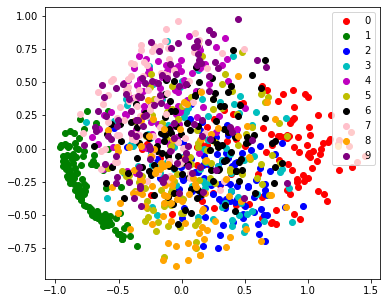

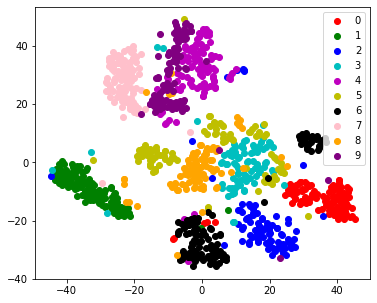

In [87]:
# TRAINED FOR 1 EPOCH, LR 1e-6
from matplotlib import pyplot as plt
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple'
numbers = [0,1,2,3,4,5,6,7,8,9]

plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,10), colors, numbers):
    plt.scatter(X_untrained_PCA[saved_labels[0:1000] == i, 0], X_untrained_PCA[saved_labels[0:1000] == i, 1], c=c, label=label)
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,10), colors, numbers):
    plt.scatter(X_untrained_TSNE[saved_labels[0:1000] == i, 0], X_untrained_TSNE[saved_labels[0:1000] == i, 1], c=c, label=label)
plt.legend()
plt.show()

In [93]:
# TRAINED FOR 10 EPOCHS, LR 1e-3
pca = PCA(n_components=2)
modelfeatures = output
pca.fit(modelfeatures)
X_untrained_PCA = pca.transform(modelfeatures)

tsne = TSNE(n_components=2)
modelfeatures = output
X_untrained_TSNE = tsne.fit_transform(modelfeatures)

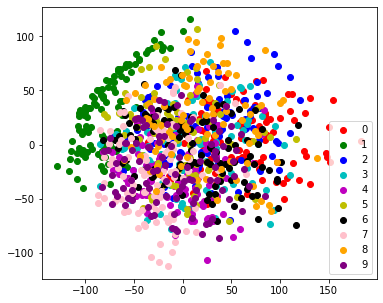

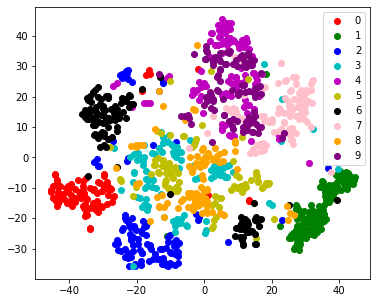

In [94]:
# TRAINED FOR 10 EPOCHS, LR 1e-3
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple'
numbers = [0,1,2,3,4,5,6,7,8,9]

plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,10), colors, numbers):
    plt.scatter(X_untrained_PCA[saved_labels[0:1000] == i, 0], X_untrained_PCA[saved_labels[0:1000] == i, 1], c=c, label=label)
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,10), colors, numbers):
    plt.scatter(X_untrained_TSNE[saved_labels[0:1000] == i, 0], X_untrained_TSNE[saved_labels[0:1000] == i, 1], c=c, label=label)
plt.legend()
plt.show()